
* Running experiment: sota_algos


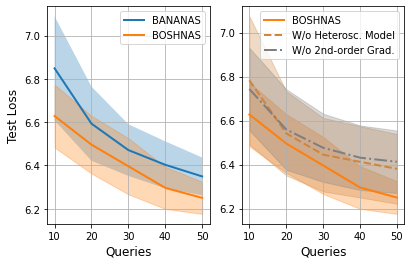

In [26]:
import os
import pickle 

from naszilla.params import *
from naszilla.nas_benchmarks import Nasbench101

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator


cp = True
eps = 0.1

save_dir = './results_output/sota_algos/'
trials = 50
queries = 50
out_file = 'round'

algo_labels = {'random': 'RS', 'evolution': 'ES', 'bananas': 'BANANAS', 'bonas': 'BONAS', 'gp_bayesopt': 'GP-BO',
    'dngo': 'DNGO', 'bohamiann': 'BOHAMIANN', 'local_search': 'LS', 'gcn_predictor': 'GCN', 'boshnas': 'BOSHNAS',
    'boshnas_wo_aleatoric': 'W/o Heterosc. Model', 'boshnas_wo_second_order': 'W/o 2nd-order Grad.'}

algorithm_params = algo_params('sota_algos', queries=queries)

losses = {param['algo_name']:[] for param in algorithm_params}
losses['boshnas_wo_aleatoric'] = []
losses['boshnas_wo_second_order'] = []
for i in range(trials):
    best_loss = 100
    boshnas_loss = 100
    filename = os.path.join(save_dir, '{}_{}.pkl'.format(out_file, i))
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        for j in range(len(results[0])):
            losses[results[0][j]['algo_name']].append(results[2][j])
            best_loss = min(best_loss, results[2][j][-1, -1])
            if results[0][j]['algo_name'] == 'boshnas': 
                boshnas_loss = results[2][j][-1, -1]
    if cp:
        if boshnas_loss > best_loss + eps:
            for algo in losses.keys():
                if losses[algo]: losses[algo].pop()
        
save_dirs = ['./results_output/boshnas_wo_aleatoric/', './results_output/boshnas_wo_second_order/']
for save_dir in save_dirs:
    for i in range(trials):
        filename = os.path.join(save_dir, '{}_{}.pkl'.format(out_file, i))
        with open(filename, 'rb') as f:
            results = pickle.load(f)
            for j in range(len(results[0])):
                if save_dir.endswith('boshnas_wo_aleatoric/'):
                    losses['boshnas_wo_aleatoric'].append(results[2][j])
                else:
                    losses['boshnas_wo_second_order'].append(results[2][j])


for algo, loss in losses.items():
    num_trials = len(loss); break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6.4, 4))
for algo in losses.keys():
    loss = np.mean([loss[:, 1] for loss in losses[algo]], axis=0)
    yerr=1.64*np.std([loss[:, 1] for loss in losses[algo]], axis=0)
    
    if algo == 'boshnas':
        ax1.plot(losses[algo][0][:, 0], loss, label=algo_labels[algo], linewidth=2, color='tab:orange')
        ax1.fill_between(losses[algo][0][:, 0], loss - yerr/2, loss + yerr/2, alpha=0.3, color='tab:orange')
        
        ax2.plot(losses[algo][0][:, 0], loss, label=algo_labels[algo], linewidth=2, color='tab:orange')
        ax2.fill_between(losses[algo][0][:, 0], loss - yerr/2, loss + yerr/2, alpha=0.3, color='tab:orange')
    elif algo == 'bananas':
        ax1.plot(losses[algo][0][:, 0], loss, label=algo_labels[algo], linewidth=2)
        ax1.fill_between(losses[algo][0][:, 0], loss - yerr/2, loss + yerr/2, alpha=0.3)
    elif algo == 'boshnas_wo_aleatoric':
        ax2.plot(losses[algo][0][:, 0], loss, label=algo_labels[algo], linewidth=2, color='peru', linestyle='--')
        ax2.fill_between(losses[algo][0][:, 0], loss - yerr/2, loss + yerr/2, alpha=0.3, color='peru')
    elif algo == 'boshnas_wo_second_order':
        ax2.plot(losses[algo][0][:, 0], loss, label=algo_labels[algo], linewidth=2, color='tab:grey', linestyle='-.')
        ax2.fill_between(losses[algo][0][:, 0], loss - yerr/2, loss + yerr/2, alpha=0.3, color='tab:grey')
    
ax1.grid(); ax2.grid()
ax1.set_xlabel('Queries', fontsize=12)
ax2.set_xlabel('Queries', fontsize=12)
ax1.set_ylabel('Test Loss', fontsize=12)
ax1.legend(ncol=2 if algo_params == 'all_algos' else 1)
ax2.legend(ncol=1)
fig_filename = os.path.join(save_dir, 'results.pdf') 
plt.show()